## Regresión Lineal enfocada a contaminación con Co2 

In [1]:
# Traemos las librerias 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn .preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Traemos los datos 
data = "../Data/energy.csv"
 
energy = pd.read_csv(data, delimiter=',')
# Convertimos la data a df, obtenemos punto de reinicio
df_energy = pd.DataFrame(energy) 

In [3]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55440 entries, 0 to 55439
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   55440 non-null  int64  
 1   Country                      55440 non-null  object 
 2   Energy_type                  55440 non-null  object 
 3   Year                         55440 non-null  int64  
 4   Energy_consumption           44287 non-null  float64
 5   Energy_production            44289 non-null  float64
 6   GDP                          40026 non-null  float64
 7   Population                   46014 non-null  float64
 8   Energy_intensity_per_capita  50358 non-null  float64
 9   Energy_intensity_by_GDP      50358 non-null  float64
 10  CO2_emission                 51614 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 4.7+ MB


In [4]:
df_energy.shape

(55440, 11)

In [5]:
df_energy.head(4)

,Unnamed: 0,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,Energy_intensity_per_capita,Energy_intensity_by_GDP,CO2_emission
0,0,World,all_energy_types,1980,292.899790,296.337228,27770.910281,4.298127e+06,68.145921,10.547,4946.627130
1,1,World,coal,1980,78.656134,80.114194,27770.910281,4.298127e+06,68.145921,10.547,1409.790188
2,2,World,natural_gas,1980,53.865223,54.761046,27770.910281,4.298127e+06,68.145921,10.547,1081.593377
3,3,World,petroleum_n_other_liquids,1980,132.064019,133.111109,27770.910281,4.298127e+06,68.145921,10.547,2455.243565


In [6]:
# vamos a eliminar la columna Unnamed, porque es el indice.
df_energy.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
# Verificamos duplicados
df_energy.duplicated().sum()

0

#### Entendimiento de las columnas 

1. Country
- Descripción: Nombre del país.
- Importancia: Permite segmentar y analizar las tendencias por región o nación.
2. Energy_type
- Descripción: Tipo de energía.
- Importancia: Facilita identificar el impacto ambiental según el tipo de energía.
3. Year
- Descripción: Año del registro.
- Importancia: Permite analizar tendencias temporales en las emisiones y consumo.
4. Energy_consumption
- Descripción: Energía consumida en el país.
- Importancia: Indicador clave para correlacionar el consumo con emisiones y otros factores.
5. Energy_production
- Descripción: Energía producida en el país.
- Importancia: Esencial para comparar consumo vs. producción, y su relación con emisiones.
6. GDP
- Descripción: Producto Interno Bruto (PIB) del país.
- Importancia: Relaciona la economía con el uso energético y emisiones.
7. Population
- Descripción: Población del país.
- Importancia: Permite calcular intensidades energéticas y emisiones per cápita.
8. Energy_intensity_per_capita
- Descripción: Energía consumida por persona.
- Importancia: Mide la eficiencia del uso energético a nivel individual.
9. Energy_intensity_by_GDP
- Descripción: Energía consumida por unidad de PIB.
- Importancia: Indicador de eficiencia energética económica.
10. CO2_emission
- Descripción: Emisiones de CO2 asociadas al consumo energético.
- Importancia: Variable objetivo para evaluar el impacto ambiental.

In [8]:
# Tenemos suficientes datos, vamos a eliminar todos los valores faltantes
df_energy.dropna(subset=(df_energy.columns), inplace=True)
df_energy.isna().sum()


Country                        0
Energy_type                    0
Year                           0
Energy_consumption             0
Energy_production              0
GDP                            0
Population                     0
Energy_intensity_per_capita    0
Energy_intensity_by_GDP        0
CO2_emission                   0
dtype: int64

In [9]:
# Veamos todos los años que tenemos en el dataset
df_energy['Year'].value_counts()

Year
2018    1026
2017    1025
2016    1025
2015    1025
2014    1025
2013    1025
2012    1021
2011    1020
2009    1020
2010    1019
2008    1016
2007    1015
2019    1012
2006    1007
2005    1005
2004    1005
2003    1001
2002    1000
1998     988
1999     988
2001     987
2000     987
1997     984
1996     983
1995     981
1994     967
1993     958
1992     882
1991     849
1990     837
1989     815
1988     810
1987     275
1986     275
1985     275
1984     275
1982     274
1983     274
1981     273
1980      76
Name: count, dtype: int64

In [10]:
# vamos a modificar algunas columnas para poder realizar nuestra regresion_linear
print(df_energy['Energy_type'].unique())
print(df_energy['Energy_type'].value_counts())

['all_energy_types' 'coal' 'natural_gas' 'petroleum_n_other_liquids'
 'nuclear' 'renewables_n_other']
Energy_type
renewables_n_other           6503
all_energy_types             6426
coal                         6426
natural_gas                  6410
petroleum_n_other_liquids    6409
nuclear                      1131
Name: count, dtype: int64


In [11]:
print(df_energy['Country'].unique())


['World' 'Argentina' 'Australia' 'Austria' 'Belgium' 'Bhutan' 'Botswana'
 'Brazil' 'Bulgaria' 'Canada' 'Chile' 'China' 'Denmark' 'Finland' 'France'
 'Greece' 'Guinea-Bissau' 'Hong Kong' 'India' 'Indonesia' 'Ireland'
 'Italy' 'Japan' 'Kenya' 'Liberia' 'Malaysia' 'Mauritania' 'Mauritius'
 'Mexico' 'Mozambique' 'Netherlands' 'New Zealand' 'Norway' 'Philippines'
 'Portugal' 'Romania' 'Samoa' 'Singapore' 'South Africa' 'South Korea'
 'Spain' 'Sweden' 'Switzerland' 'Taiwan' 'Thailand' 'Turkey'
 'United Arab Emirates' 'United Kingdom' 'United States' 'Venezuela'
 'Nigeria' 'Afghanistan' 'Albania' 'Algeria' 'Angola'
 'Antigua and Barbuda' 'Aruba' 'Bahrain' 'Bangladesh' 'Barbados' 'Belize'
 'Benin' 'Bermuda' 'Bolivia' 'British Virgin Islands' 'Brunei'
 'Burkina Faso' 'Burma' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Cayman Islands' 'Chad' 'Colombia' 'Comoros' 'Congo-Brazzaville'
 'Congo-Kinshasa' 'Costa Rica' 'Cuba' 'Côte d’Ivoire' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Sal

In [12]:
# Recuento de cada variable unica en la columna `Country`
country_counts = df_energy['Country'].value_counts()
print(country_counts)


# Obtener la cantidad de valores únicos en la columna 'Country'
num_unicos = df_energy['Country'].nunique()
print("Tenemos estos países unicos:", num_unicos)

Country
World                       240
United States               240
Finland                     236
Argentina                   236
United Kingdom              236
                           ... 
Montenegro                   66
Serbia                       66
Kosovo                       56
Northern Mariana Islands     52
South Sudan                  36
Name: count, Length: 199, dtype: int64
Tenemos estos países unicos: 199


In [13]:
# Vamos convertir la columna `Energy_type` a string
df_energy['Energy_type'] = df_energy['Energy_type'].astype(str)

# Inicializamos el codificador
label_encoder = LabelEncoder()

df_energy['Energy_type_encoded'] = label_encoder.fit_transform(df_energy['Energy_type'])

# Muestra el mapeo de valores
print("Clases encontradas por el codificador:", label_encoder.classes_)

Clases encontradas por el codificador: ['all_energy_types' 'coal' 'natural_gas' 'nuclear'
 'petroleum_n_other_liquids' 'renewables_n_other']


#### Procesamos los datos con Label encoding, ahora las variables categoricas son valores numericos

- all_energy_types = 0
- coal = 1
- natural_gas = 2
- nuclear = 3
- petroleum_n_other_liquids = 4
- renewables_n_other = 5

In [14]:
df_energy.columns

Index(['Country', 'Energy_type', 'Year', 'Energy_consumption',
       'Energy_production', 'GDP', 'Population', 'Energy_intensity_per_capita',
       'Energy_intensity_by_GDP', 'CO2_emission', 'Energy_type_encoded'],
      dtype='object')

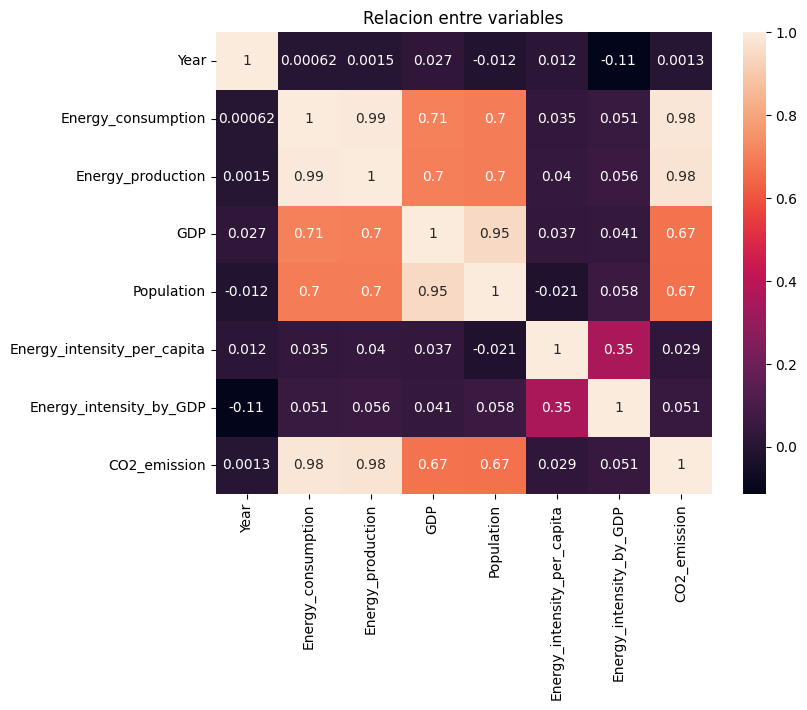

In [15]:
correlacion = df_energy[['Year', 'Energy_consumption',
       'Energy_production', 'GDP', 'Population', 'Energy_intensity_per_capita',
       'Energy_intensity_by_GDP', 'CO2_emission']]

corr = correlacion.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title("Relacion entre variables")
plt.show()

#### Comenzamos con la regresión linear

In [16]:
# Seleccion de variables 

X = df_energy[['Year', 'Energy_type_encoded','Energy_consumption', 'Energy_production', 'GDP', 'Population',
               'Energy_intensity_per_capita', 'Energy_intensity_by_GDP']]
y = df_energy['CO2_emission']

In [17]:
# Dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Datos de entrenamiento: {X_train.shape}, Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (26644, 8), Datos de prueba: (6661, 8)


In [18]:
# Creamos el objeto de Regresión Linear
model = LinearRegression()

In [19]:
# Entrenamos el modelo 
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# Generar predicciones 
y_pred = model.predict(X_test)

print(y_pred)

[ 13.89619344 -10.49283328  -1.52326939 ...   8.11331143  -4.87050059
   5.43358816]


In [21]:
# Para obtener la pendiente
print('Coeficientes: \n', model.coef_)
# Para obtener el intercepto
print('intercepción: \n', model.intercept_)


Coeficientes: 
 [ 2.87234097e-01 -5.35772774e+00  6.75575179e+01 -4.48928991e+00
 -5.71937443e-03 -1.11175291e-05 -5.17125198e-02  9.19048585e-01]
intercepción: 
 -563.0530706017393


In [22]:
# Evaluamos el modelo 
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.95
MAE: 29.72
RMSE: 173.03


                      Variable  Coeficiente
0                         Year     0.287234
1          Energy_type_encoded    -5.357728
2           Energy_consumption    67.557518
3            Energy_production    -4.489290
4                          GDP    -0.005719
5                   Population    -0.000011
6  Energy_intensity_per_capita    -0.051713
7      Energy_intensity_by_GDP     0.919049


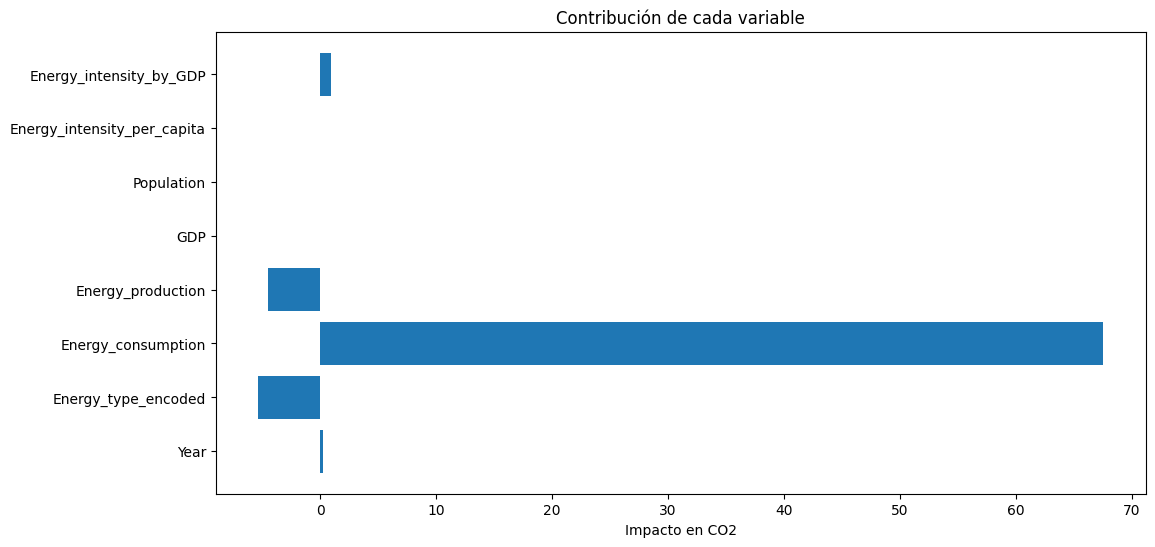

In [23]:
# Coeficientes del modelo
coeficientes = pd.DataFrame({'Variable': X.columns, 'Coeficiente': model.coef_})
print(coeficientes)

# Graficar mejores coeficientes
plt.figure(figsize=(12, 6))
plt.barh(coeficientes['Variable'], coeficientes['Coeficiente'])
plt.xlabel("Impacto en CO2")
plt.title("Contribución de cada variable")
plt.show()


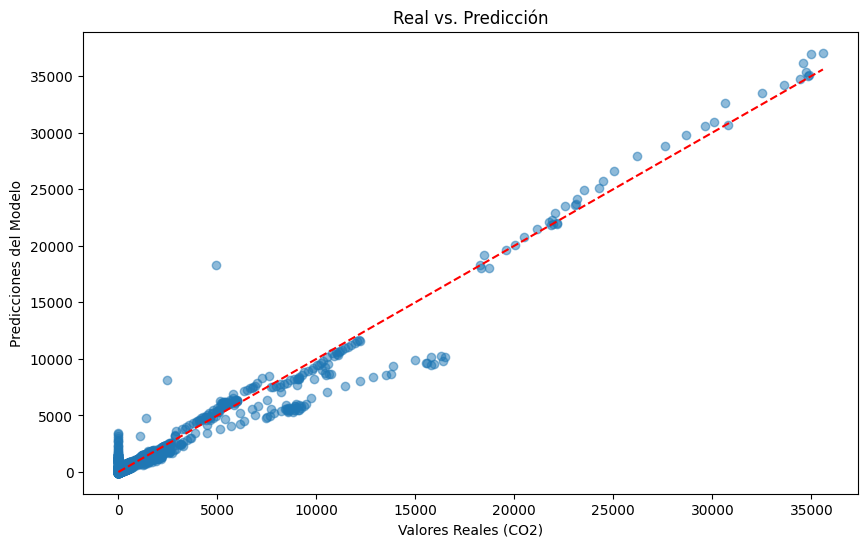

In [24]:
# Predecir valores 
y_pred1 = model.predict(X)

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred1, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Línea de referencia
plt.xlabel("Valores Reales (CO2)")
plt.ylabel("Predicciones del Modelo")
plt.title("Real vs. Predicción")
plt.show()

##### Ahora solo con una variable

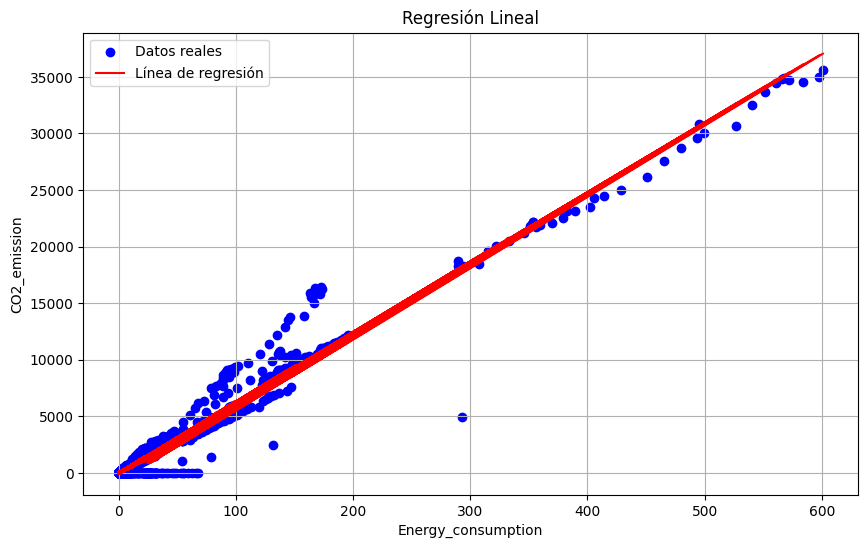

In [25]:
X_variable = X['Energy_consumption']

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(X_variable, y, color='blue', label='Datos reales')
plt.plot(X_variable, y_pred1, color='red', label='Línea de regresión')
plt.title('Regresión Lineal')
plt.xlabel('Energy_consumption')
plt.ylabel('CO2_emission')
plt.legend()
plt.grid(True)
plt.show()

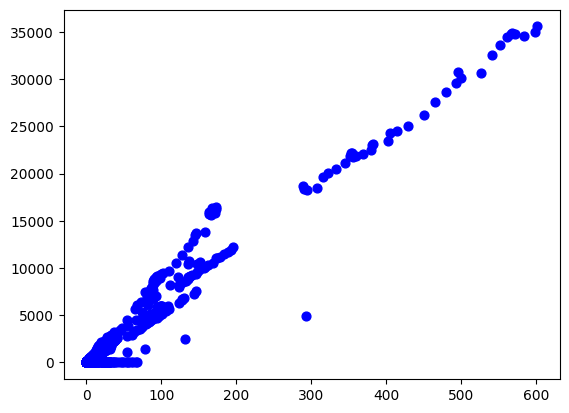

In [26]:
variable_x = X_train['Energy_consumption']
variable_y = y_train

plt.scatter(variable_x, variable_y, c='blue', s=40)
plt.show()

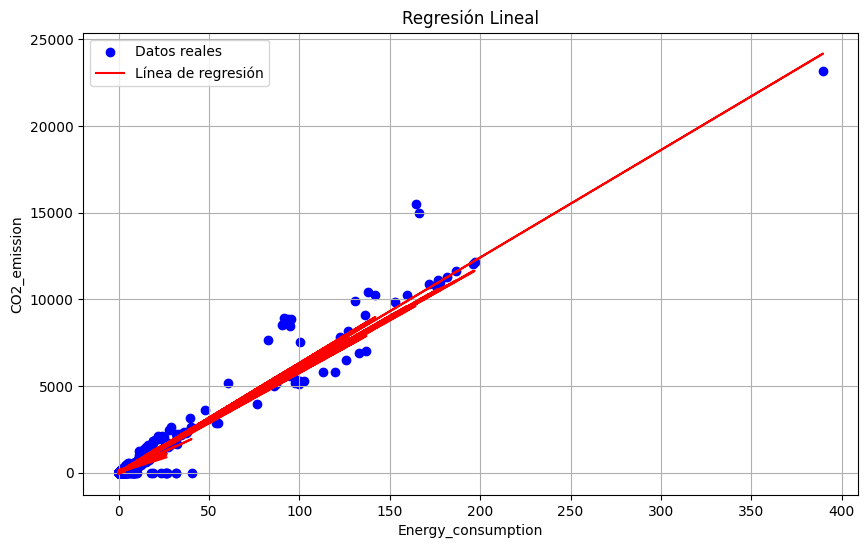

In [27]:
# Usamos la variable `Energy_consumption` - X_test
variable_x = X_test['Energy_consumption']

# Predicciones del modelo
y_pred_con = model.predict(X_test)

# Graficamos
plt.figure(figsize=(10, 6))
plt.scatter(variable_x, y_test, color='blue', label='Datos reales')
plt.plot(variable_x, y_pred_con, color='red', label='Línea de regresión')
plt.title('Regresión Lineal')
plt.xlabel('Energy_consumption')
plt.ylabel('CO2_emission')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Crear nuevo modelo solo con 'Energy_consumption'
X_single = X[['Energy_consumption']]
model_single = LinearRegression()
model_single.fit(X_single, y)

# Ahora puedes predecir y calcular métricos solo con este modelo
y_pred_single = model_single.predict(X_test[['Energy_consumption']])


In [29]:
# Evaluamos el modelo 
r2 = r2_score(y_test, y_pred_single)
mae = mean_absolute_error(y_test, y_pred_single)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_single))


print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.95
MAE: 25.48
RMSE: 174.32


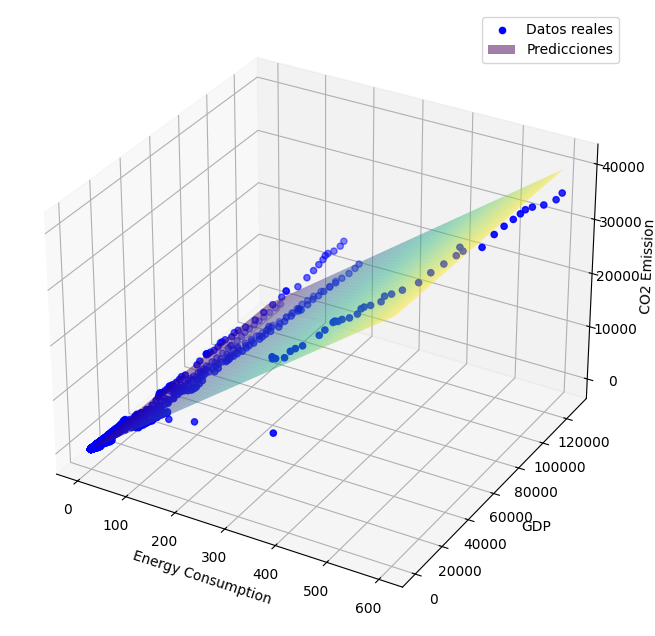

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Datos reales: Usar 2 variables (ej: Energy_consumption vs GDP)
ax.scatter(
    X['Energy_consumption'],  # Eje X
    X['GDP'],                 # Eje Y
    y,                        # Eje Z (CO2 real)
    c='blue',
    label='Datos reales'
)

# Crear malla para superficie de predicción (usando Energy_consumption y GDP)
x_surf = np.linspace(X['Energy_consumption'].min(), X['Energy_consumption'].max(), 50)
y_surf = np.linspace(X['GDP'].min(), X['GDP'].max(), 50)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

# DataFrame temporal con el ORDEN CORRECTO de columnas
temp_df = pd.DataFrame({
    'Year': np.full(x_surf.size, X['Year'].mean()),  # Mismo valor para toda la malla
    'Energy_type_encoded': X['Energy_type_encoded'].mode()[0],  # Valor más frecuente
    'Energy_consumption': x_surf.ravel(),
    'Energy_production': np.full(x_surf.size, X['Energy_production'].mean()),
    'GDP': y_surf.ravel(),
    'Population': np.full(x_surf.size, X['Population'].mean()),
    'Energy_intensity_per_capita': np.full(x_surf.size, X['Energy_intensity_per_capita'].mean()),
    'Energy_intensity_by_GDP': np.full(x_surf.size, X['Energy_intensity_by_GDP'].mean())
}, columns=X.columns)  # <- Orden explícito según X.columns

# Predecir CO2 para la malla
z_pred = model.predict(temp_df).reshape(x_surf.shape)

# Graficar superficie
ax.plot_surface(
    x_surf,
    y_surf,
    z_pred,
    cmap='viridis',
    alpha=0.5,
    label='Predicciones'
)

ax.set_xlabel("Energy Consumption")
ax.set_ylabel("GDP")
ax.set_zlabel("CO2 Emission")
plt.legend()
plt.show()